
# Correlations (endog / exog) before regressions

Goal:
1) Exog vs exog correlations (multicollinearity check).
2) Endog vs endog correlations (spillover comovements).
3) Endog vs exog correlations (direct relationships).
4) Identify highly correlated pairs (|corr| above a threshold).


In [23]:
# Imports and paths

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/endogenous/prices/differenced")
ENDOG_PATH = OUT_DIR / "endogenous_tsi_diff.parquet"
EXOG_PATH  = Path("../data/exogenous/all_exog_ready.parquet")

RESULTS_DIR = Path("../data/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("ENDOG:", ENDOG_PATH)
print("EXOG :", EXOG_PATH)
print("RESULTS_DIR:", RESULTS_DIR)


ENDOG: ..\data\endogenous\prices\differenced\endogenous_tsi_diff.parquet
EXOG : ..\data\exogenous\all_exog_ready.parquet
RESULTS_DIR: ..\data\results


In [24]:
# Load raw data

endog_raw = pd.read_parquet(ENDOG_PATH)
exog_raw  = pd.read_parquet(EXOG_PATH)

endog_raw["date"] = pd.to_datetime(endog_raw["date"])
endog = endog_raw.set_index("date").sort_index()

exog_raw["date"] = pd.to_datetime(exog_raw["date"])
exog = exog_raw.set_index("date").sort_index()

display(endog.head())
display(exog.head())

print("endog shape:", endog.shape, "| cols:", list(endog.columns))
print("exog  shape:", exog.shape,  "| cols:", list(exog.columns))



,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar
date,,,,
2022-05-21,0.565159,0.353851,0.318845,0.464115
2022-05-22,0.028779,0.053486,0.018242,0.090025
2022-05-23,0.017773,0.001561,0.009926,-0.035204
2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416
2022-05-25,0.021521,-0.015650,-0.001137,-0.004788


,co2,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_cac_eur_pts,d_ibex_eur_pts,iberian_exception
date,,,,,,,,,,,,
2021-05-22,51.29,119301.0,-2942.129167,1609.212500,5271.569824,0.000000,0.000000,-70887.0,-98050.0,0.000000,0.000000,0
2021-05-23,51.29,110127.0,-2921.383333,1017.291667,5271.569824,0.000000,0.000000,-46933.0,-38600.0,0.000000,0.000000,0
2021-05-24,52.68,129947.0,-3279.625000,1429.829167,5221.720215,-0.030001,-0.042563,89538.0,7100.0,22.080078,1.500000,0
2021-05-25,51.24,134131.0,-2847.470833,400.925000,5221.720215,1.430000,0.004210,22154.0,175500.0,-18.220215,3.200195,0
2021-05-26,52.81,134276.0,-3178.591667,666.687500,5220.339844,0.240000,0.508413,4884.0,-8950.0,1.330078,-11.799805,0


endog shape: (1076, 4) | cols: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
exog  shape: (1440, 12) | cols: ['co2', 'load_energy_mwh_pt', 'flow_net_mw_ES_FR', 'flow_net_mw_ES_PT', 'psi_eur_pts', 'd_TTF', 'd_coal', 'd_load_energy_mwh_es', 'd_load_energy_mwh_fr', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'iberian_exception']


In [25]:
# Variable selection
# - exog_cols=None uses all exog columns
# - or define a specific list if you have too many regressors

exog_cols = None  # example: ["d_TTF", "d_co2", "d_coal", "d_cac_eur_pts", "d_ibex_eur_pts", "d_psi_eur_pts"]

endog_names = list(endog.columns)

if exog_cols is None:
    exog_names = list(exog.columns)
else:
    missing = [c for c in exog_cols if c not in exog.columns]
    if missing:
        raise ValueError(f"Missing exog_cols in exog: {missing}")
    exog_names = exog_cols

print("N endog:", len(endog_names))
print("N exog :", len(exog_names))


N endog: 4
N exog : 12


In [26]:
# Align on dates (inner join) + drop rows with missing values in used columns

data = endog.join(exog[exog_names], how="inner")
print("After join:", data.shape, "|", data.index.min(), "->", data.index.max())

data = data[endog_names + exog_names].dropna()
print("After dropna:", data.shape, "|", data.index.min(), "->", data.index.max())

display(data.head())


After join: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
After dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00


,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar,co2,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_cac_eur_pts,d_ibex_eur_pts,iberian_exception
date,,,,,,,,,,,,,,,,
2022-05-21,0.565159,0.353851,0.318845,0.464115,80.02,114970.0,-1267.886957,1304.791304,5921.160156,0.00,0.000000,-95590.0,-177850.0,0.000000,0.000000,0
2022-05-22,0.028779,0.053486,0.018242,0.090025,80.02,114745.0,-1280.312500,1758.000000,5921.160156,0.00,0.000000,-23502.0,3000.0,0.000000,0.000000,0
2022-05-23,0.017773,0.001561,0.009926,-0.035204,78.18,133289.0,-184.662500,539.587500,6079.509766,-4.61,-6.869052,1892133.0,153100.0,73.500000,141.299805,0
2022-05-24,-0.010183,-0.026224,-0.020802,-0.033416,80.96,136178.0,49.637500,236.762500,6130.899902,1.22,-1.999857,148337.0,15950.0,-105.600098,5.400391,0
2022-05-25,0.021521,-0.015650,-0.001137,-0.004788,81.03,137841.0,457.479167,1438.329167,6184.839844,3.57,0.622824,-35668.0,-31200.0,45.500000,129.000000,0


In [27]:
# Quick descriptive stats 

desc = data.describe().T
display(desc[["mean", "std", "min", "max"]].head(20))

# Near-constant columns (correlations can be NaN or misleading)
near_const = desc[desc["std"].fillna(0) < 1e-12].index.tolist()
print("Near-constant columns (std ~ 0):", near_const)


,mean,std,min,max
d_tsi_mhar_recov_neg,0.002599,0.207570,-1.183689,1.492161e+00
d_tsi_mhar_recov_pos,0.002469,0.176195,-1.084911,1.030624e+00
d_tsi_mhar_recov,0.000850,0.174010,-1.170950,1.301299e+00
d_tsi_mhar_revar,0.000187,0.190516,-1.040986,1.174769e+00
co2,75.064470,10.070930,0.000000,9.782000e+01
load_energy_mwh_pt,139955.657063,15234.693800,88024.000000,1.808540e+05
flow_net_mw_ES_FR,311.522769,1781.623936,-3524.333333,3.608708e+03
flow_net_mw_ES_PT,992.419635,1119.097818,-2811.975000,3.391550e+03
psi_eur_pts,6252.689063,358.253212,5190.279785,6.988330e+03
d_TTF,-0.036256,4.743372,-66.600000,3.220000e+01


Near-constant columns (std ~ 0): []


In [28]:
# Correlation method
# - Pearson: linear correlation
# - Spearman: rank-based (more robust to outliers / non-linear monotonic relationships)
# - Kendall: also rank-based, usually slower

method = "pearson"  
print("Correlation method:", method)


Correlation method: pearson


In [29]:
# Exog-exog correlation matrix (multicollinearity check)

corr_exog = data[exog_names].corr(method=method)
display(corr_exog.iloc[:10, :10])

corr_exog_path = RESULTS_DIR / f"corr_exog_exog_{method}.csv"
corr_exog.to_csv(corr_exog_path)
print("Saved:", corr_exog_path)


,co2,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_cac_eur_pts
co2,1.000000,-0.134569,0.040108,0.075558,-0.423373,0.045988,0.008977,-0.010049,-0.008195,-0.016038
load_energy_mwh_pt,-0.134569,1.000000,0.112974,-0.288135,0.079308,-0.016057,-0.019302,0.340467,0.173206,0.041678
flow_net_mw_ES_FR,0.040108,0.112974,1.000000,-0.433977,-0.275871,-0.031808,-0.003896,-0.023535,-0.038512,0.047864
flow_net_mw_ES_PT,0.075558,-0.288135,-0.433977,1.000000,0.140138,0.037388,0.052464,-0.070267,-0.008715,-0.025638
psi_eur_pts,-0.423373,0.079308,-0.275871,0.140138,1.000000,0.058413,0.074221,-0.000328,-0.009914,-0.008182
d_TTF,0.045988,-0.016057,-0.031808,0.037388,0.058413,1.000000,0.168855,-0.022175,0.003282,-0.053412
d_coal,0.008977,-0.019302,-0.003896,0.052464,0.074221,0.168855,1.000000,-0.052731,-0.006934,-0.076235
d_load_energy_mwh_es,-0.010049,0.340467,-0.023535,-0.070267,-0.000328,-0.022175,-0.052731,1.000000,0.469420,-0.014843
d_load_energy_mwh_fr,-0.008195,0.173206,-0.038512,-0.008715,-0.009914,0.003282,-0.006934,0.469420,1.000000,0.002178
d_cac_eur_pts,-0.016038,0.041678,0.047864,-0.025638,-0.008182,-0.053412,-0.076235,-0.014843,0.002178,1.000000


Saved: ..\data\results\corr_exog_exog_pearson.csv


In [30]:
# Endog-endog correlation matrix

corr_endog = data[endog_names].corr(method=method)
display(corr_endog)

corr_endog_path = RESULTS_DIR / f"corr_endog_endog_{method}.csv"
corr_endog.to_csv(corr_endog_path)
print("Saved:", corr_endog_path)


,d_tsi_mhar_recov_neg,d_tsi_mhar_recov_pos,d_tsi_mhar_recov,d_tsi_mhar_revar
d_tsi_mhar_recov_neg,1.000000,0.512596,0.718792,0.549439
d_tsi_mhar_recov_pos,0.512596,1.000000,0.849596,0.666366
d_tsi_mhar_recov,0.718792,0.849596,1.000000,0.734375
d_tsi_mhar_revar,0.549439,0.666366,0.734375,1.000000


Saved: ..\data\results\corr_endog_endog_pearson.csv


In [31]:
# Endog-exog cross-correlation matrix
# (rows = endog, columns = exog)

corr_cross = pd.DataFrame(index=endog_names, columns=exog_names, dtype=float)

for y in endog_names:
    for x in exog_names:
        corr_cross.loc[y, x] = data[y].corr(data[x], method=method)

display(corr_cross.iloc[:, :10])

corr_cross_path = RESULTS_DIR / f"corr_endog_exog_{method}.csv"
corr_cross.to_csv(corr_cross_path)
print("Saved:", corr_cross_path)


,co2,load_energy_mwh_pt,flow_net_mw_ES_FR,flow_net_mw_ES_PT,psi_eur_pts,d_TTF,d_coal,d_load_energy_mwh_es,d_load_energy_mwh_fr,d_cac_eur_pts
d_tsi_mhar_recov_neg,-0.026080,-0.044745,-0.071887,-0.059869,0.010898,-0.065357,-0.010150,0.015033,-0.011444,-0.026462
d_tsi_mhar_recov_pos,-0.013715,-0.024419,-0.093624,-0.050819,0.006696,-0.035900,-0.018000,0.031843,0.053026,-0.019453
d_tsi_mhar_recov,-0.038488,-0.010103,-0.071242,-0.073538,0.011640,-0.043296,-0.033155,0.068455,0.030887,-0.031356
d_tsi_mhar_revar,-0.021015,-0.041661,-0.077425,-0.049821,-0.014841,-0.005710,-0.029004,0.033938,0.019697,-0.038757


Saved: ..\data\results\corr_endog_exog_pearson.csv


Saved figure: ..\data\results\heatmap_corr_endog_endog_pearson.png


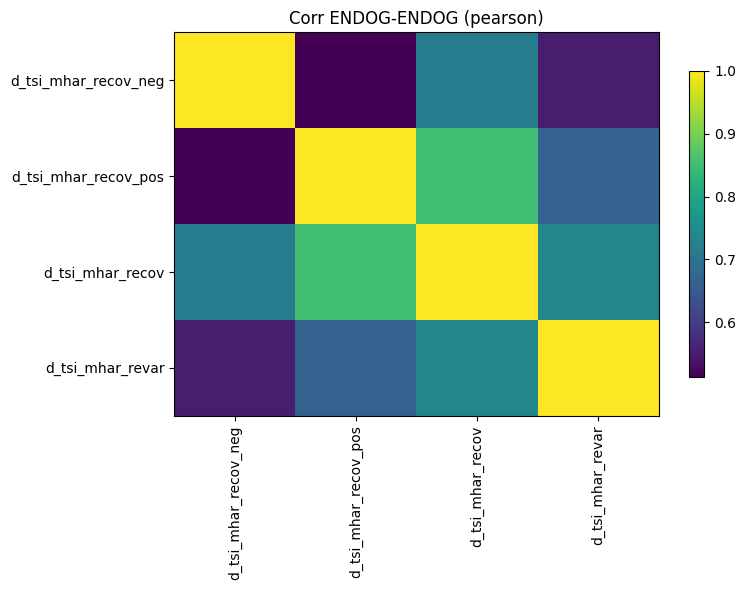

In [32]:
# Heatmap

def plot_heatmap(mat: pd.DataFrame, title: str, save_path: Path | None = None):
    M = mat.values.astype(float)
    plt.figure(figsize=(max(8, 0.35*mat.shape[1]), max(6, 0.35*mat.shape[0])))
    im = plt.imshow(M, aspect="auto", interpolation="nearest")
    plt.colorbar(im, shrink=0.8)
    plt.title(title)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_path)
    plt.show()

plot_heatmap(corr_endog, f"Corr ENDOG-ENDOG ({method})",
             RESULTS_DIR / f"heatmap_corr_endog_endog_{method}.png")


Saved figure: ..\data\results\heatmap_corr_exog_exog_top25_pearson.png


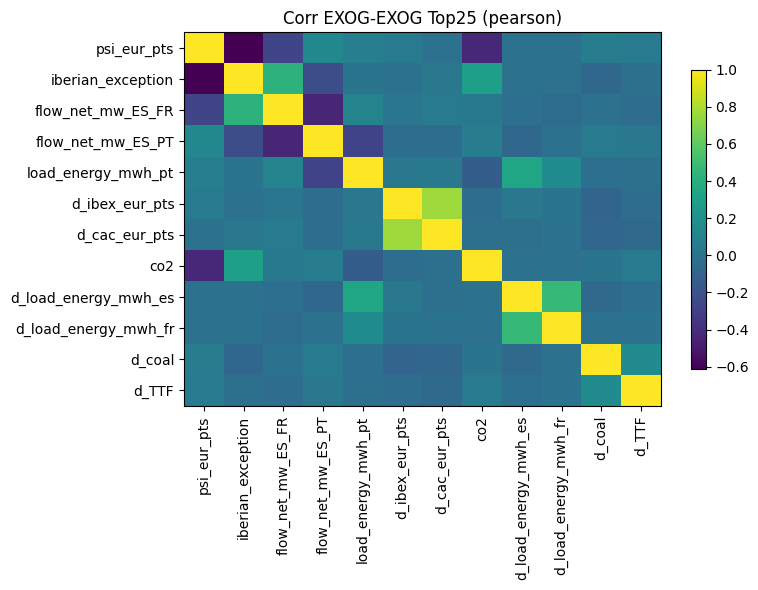

In [33]:
# Exog-exog heatmap 
# Select top N variables by "connectivity" (sum of absolute correlations)

topN = 25

score = corr_exog.abs().sum().sort_values(ascending=False)
top_vars = score.head(topN).index.tolist()

corr_exog_top = corr_exog.loc[top_vars, top_vars]
plot_heatmap(corr_exog_top, f"Corr EXOG-EXOG Top{topN} ({method})",
             RESULTS_DIR / f"heatmap_corr_exog_exog_top{topN}_{method}.png")


Saved figure: ..\data\results\heatmap_corr_endog_exog_subset_pearson.png


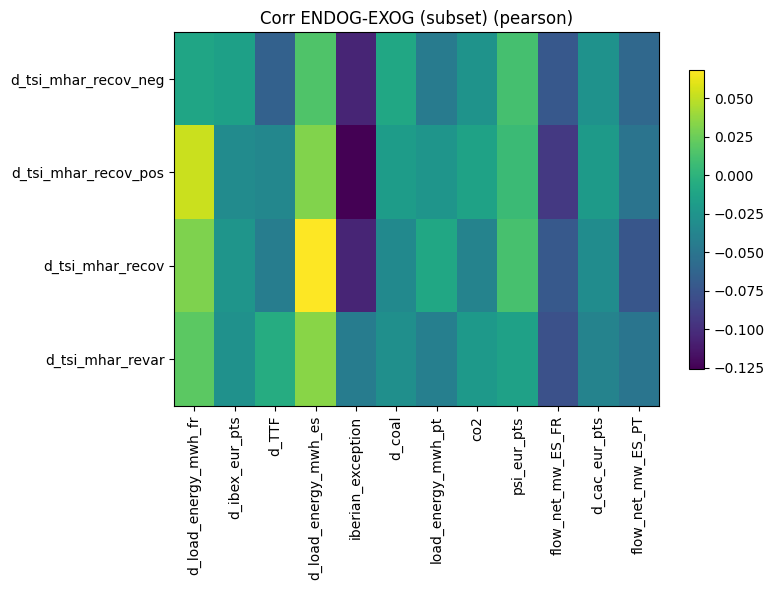

Subset exogs (n=12):
['d_load_energy_mwh_fr', 'd_ibex_eur_pts', 'd_TTF', 'd_load_energy_mwh_es', 'iberian_exception', 'd_coal', 'load_energy_mwh_pt', 'co2', 'psi_eur_pts', 'flow_net_mw_ES_FR', 'd_cac_eur_pts', 'flow_net_mw_ES_PT']


In [34]:
# Endog-exog heatmap

topK = 15

selected_exogs = set()
for y in endog_names:
    selected_exogs |= set(corr_cross.loc[y].abs().sort_values(ascending=False).head(topK).index)

selected_exogs = list(selected_exogs)

corr_cross_sub = corr_cross[selected_exogs]
plot_heatmap(corr_cross_sub, f"Corr ENDOG-EXOG (subset) ({method})",
             RESULTS_DIR / f"heatmap_corr_endog_exog_subset_{method}.png")

print(f"Subset exogs (n={len(selected_exogs)}):")
print(selected_exogs)


In [35]:
# List highly correlated exog-exog pairs (helps detect redundancy / multicollinearity)

threshold = 0.8

pairs = []
C = corr_exog.copy()
cols = C.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        v = C.iloc[i, j]
        if pd.notna(v) and abs(v) >= threshold:
            pairs.append((cols[i], cols[j], v))

high_corr_exog_pairs = pd.DataFrame(pairs, columns=["var1", "var2", "corr"]) \
                        .sort_values("corr", key=np.abs, ascending=False)

display(high_corr_exog_pairs.head(50))



,var1,var2,corr


## Correlations with lags

ENDOG–EXOG cross-correlations with lags (1 to 5)

We compute Pearson correlations between ENDOG_t and EXOG_{t-L} for L=1..5.


In [19]:
# %%
# Imports and paths

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("../data/endogenous/prices/differenced")
ENDOG_PATH = OUT_DIR / "endogenous_tsi_diff.parquet"
EXOG_PATH  = Path("../data/exogenous/all_exog_ready.parquet")

RESULTS_DIR = Path("../data/results/corr_lags")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("ENDOG:", ENDOG_PATH)
print("EXOG :", EXOG_PATH)
print("RESULTS_DIR:", RESULTS_DIR)


ENDOG: ..\data\endogenous\prices\differenced\endogenous_tsi_diff.parquet
EXOG : ..\data\exogenous\all_exog_ready.parquet
RESULTS_DIR: ..\data\results\corr_lags


In [20]:
# Variable selection

exog_cols = None   # None = use all exog columns; or set a list
endog_names = list(endog.columns)

if exog_cols is None:
    exog_names = list(exog.columns)
else:
    missing = [c for c in exog_cols if c not in exog.columns]
    if missing:
        raise ValueError(f"Missing exog columns: {missing}")
    exog_names = exog_cols

print("N endog:", len(endog_names))
print("N exog :", len(exog_names))


N endog: 4
N exog : 12


In [21]:
# Heatmap helper (matplotlib only, no seaborn)

def plot_heatmap(mat: pd.DataFrame, title: str, save_path: Path | None = None):
    M = mat.values.astype(float)
    plt.figure(figsize=(max(8, 0.35*mat.shape[1]), max(6, 0.35*mat.shape[0])))
    im = plt.imshow(M, aspect="auto", interpolation="nearest")
    plt.colorbar(im, shrink=0.8)
    plt.title(title)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print("Saved figure:", save_path)
    plt.show()



##############################################################################################################
LAG = 1 | df shape after join+dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
##############################################################################################################
Saved full cross-corr CSV: ..\data\results\corr_lags\corr_endog_exog_lag1_pearson.csv


,lag,endog,exog,corr,abs_corr
24,1,d_tsi_mhar_recov,iberian_exception,-0.106485,0.106485
25,1,d_tsi_mhar_recov,flow_net_mw_ES_PT,-0.092415,0.092415
26,1,d_tsi_mhar_recov,load_energy_mwh_pt,-0.065579,0.065579
27,1,d_tsi_mhar_recov,d_flow_net_mw_ES_FR,-0.045459,0.045459
28,1,d_tsi_mhar_recov,d_TTF,-0.025719,0.025719
29,1,d_tsi_mhar_recov,d_cac_eur_pts,-0.023172,0.023172
30,1,d_tsi_mhar_recov,d_co2,0.015570,0.015570
31,1,d_tsi_mhar_recov,d_coal,0.010428,0.010428
32,1,d_tsi_mhar_recov,d_load_energy_mwh_es,0.009186,0.009186
33,1,d_tsi_mhar_recov,d_load_energy_mwh_fr,0.007705,0.007705


Saved top pairs CSV: ..\data\results\corr_lags\top_endog_exog_lag1_pearson.csv
Saved figure: ..\data\results\corr_lags\heatmap_corr_endog_exog_lag1_pearson_subset.png


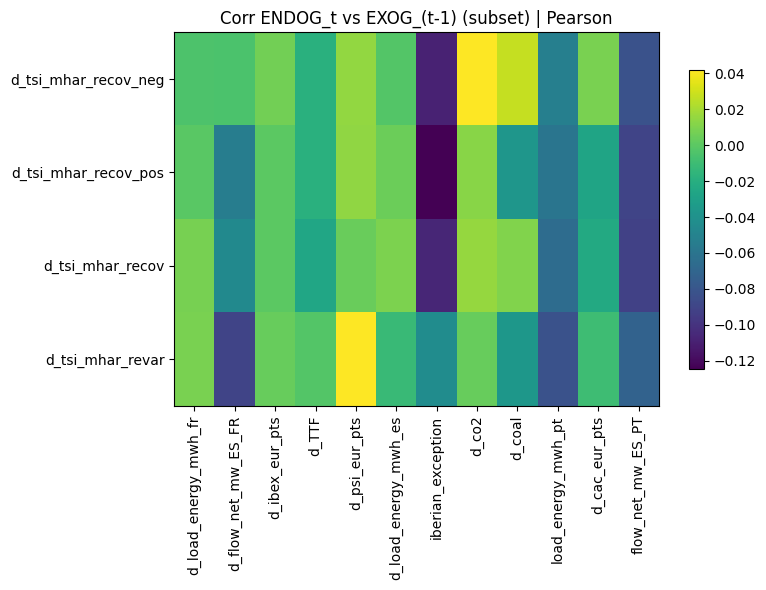


##############################################################################################################
LAG = 2 | df shape after join+dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
##############################################################################################################
Saved full cross-corr CSV: ..\data\results\corr_lags\corr_endog_exog_lag2_pearson.csv


,lag,endog,exog,corr,abs_corr
24,2,d_tsi_mhar_recov,iberian_exception,-0.107706,0.107706
25,2,d_tsi_mhar_recov,load_energy_mwh_pt,-0.060940,0.060940
26,2,d_tsi_mhar_recov,flow_net_mw_ES_PT,-0.055807,0.055807
27,2,d_tsi_mhar_recov,d_load_energy_mwh_fr,-0.046964,0.046964
28,2,d_tsi_mhar_recov,d_load_energy_mwh_es,-0.039243,0.039243
29,2,d_tsi_mhar_recov,d_flow_net_mw_ES_FR,0.022743,0.022743
30,2,d_tsi_mhar_recov,d_psi_eur_pts,0.010794,0.010794
31,2,d_tsi_mhar_recov,d_co2,0.009579,0.009579
32,2,d_tsi_mhar_recov,d_TTF,0.007367,0.007367
33,2,d_tsi_mhar_recov,d_coal,-0.006602,0.006602


Saved top pairs CSV: ..\data\results\corr_lags\top_endog_exog_lag2_pearson.csv
Saved figure: ..\data\results\corr_lags\heatmap_corr_endog_exog_lag2_pearson_subset.png


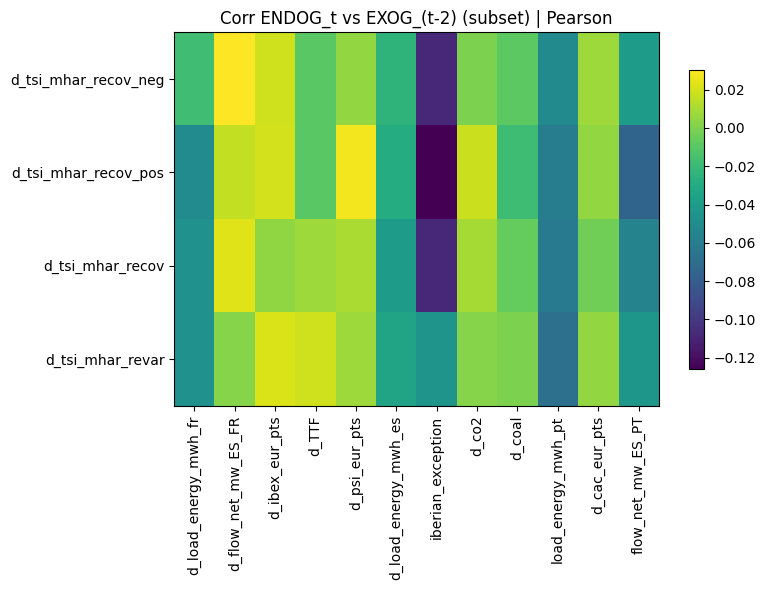


##############################################################################################################
LAG = 3 | df shape after join+dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
##############################################################################################################
Saved full cross-corr CSV: ..\data\results\corr_lags\corr_endog_exog_lag3_pearson.csv


,lag,endog,exog,corr,abs_corr
24,3,d_tsi_mhar_recov,iberian_exception,-0.107103,0.107103
25,3,d_tsi_mhar_recov,d_TTF,-0.058830,0.058830
26,3,d_tsi_mhar_recov,d_coal,-0.040573,0.040573
27,3,d_tsi_mhar_recov,flow_net_mw_ES_PT,-0.038620,0.038620
28,3,d_tsi_mhar_recov,d_cac_eur_pts,-0.036094,0.036094
29,3,d_tsi_mhar_recov,d_ibex_eur_pts,-0.033063,0.033063
30,3,d_tsi_mhar_recov,d_psi_eur_pts,-0.025636,0.025636
31,3,d_tsi_mhar_recov,d_flow_net_mw_ES_FR,0.025545,0.025545
32,3,d_tsi_mhar_recov,load_energy_mwh_pt,-0.016219,0.016219
33,3,d_tsi_mhar_recov,d_load_energy_mwh_es,-0.009495,0.009495


Saved top pairs CSV: ..\data\results\corr_lags\top_endog_exog_lag3_pearson.csv
Saved figure: ..\data\results\corr_lags\heatmap_corr_endog_exog_lag3_pearson_subset.png


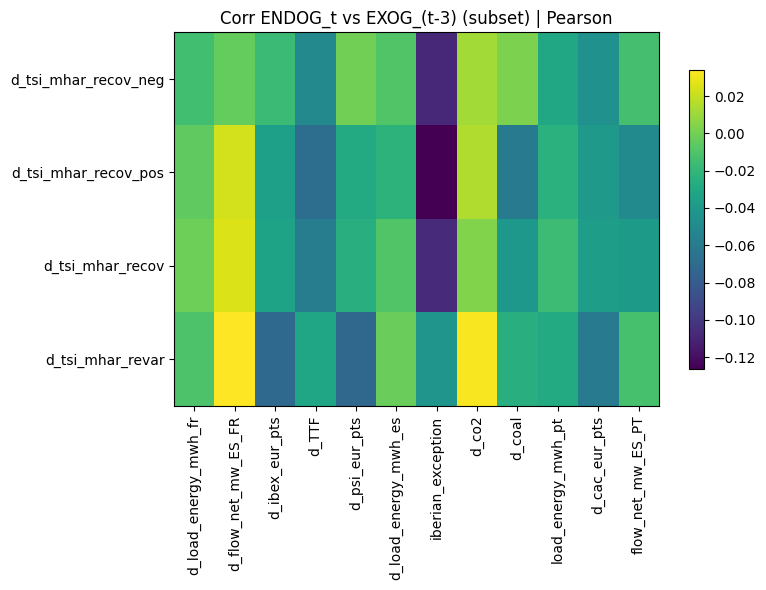


##############################################################################################################
LAG = 4 | df shape after join+dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
##############################################################################################################
Saved full cross-corr CSV: ..\data\results\corr_lags\corr_endog_exog_lag4_pearson.csv


,lag,endog,exog,corr,abs_corr
24,4,d_tsi_mhar_recov,iberian_exception,-0.111628,0.111628
25,4,d_tsi_mhar_recov,d_ibex_eur_pts,0.067701,0.067701
26,4,d_tsi_mhar_recov,flow_net_mw_ES_PT,-0.060929,0.060929
27,4,d_tsi_mhar_recov,d_cac_eur_pts,0.059503,0.059503
28,4,d_tsi_mhar_recov,d_load_energy_mwh_fr,0.039168,0.039168
29,4,d_tsi_mhar_recov,d_coal,-0.039150,0.039150
30,4,d_tsi_mhar_recov,d_flow_net_mw_ES_FR,-0.028272,0.028272
31,4,d_tsi_mhar_recov,d_psi_eur_pts,0.027667,0.027667
32,4,d_tsi_mhar_recov,d_load_energy_mwh_es,0.026382,0.026382
33,4,d_tsi_mhar_recov,d_co2,-0.024113,0.024113


Saved top pairs CSV: ..\data\results\corr_lags\top_endog_exog_lag4_pearson.csv
Saved figure: ..\data\results\corr_lags\heatmap_corr_endog_exog_lag4_pearson_subset.png


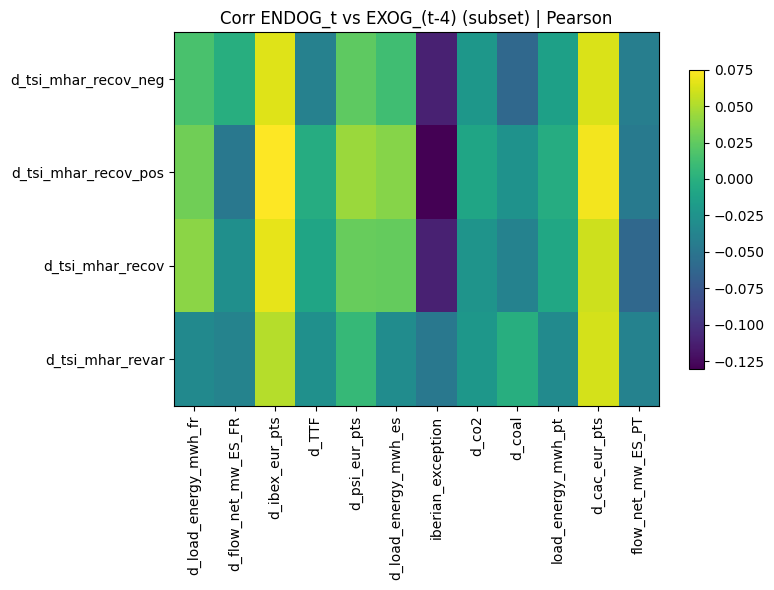


##############################################################################################################
LAG = 5 | df shape after join+dropna: (1076, 16) | 2022-05-21 00:00:00 -> 2025-04-30 00:00:00
##############################################################################################################
Saved full cross-corr CSV: ..\data\results\corr_lags\corr_endog_exog_lag5_pearson.csv


,lag,endog,exog,corr,abs_corr
24,5,d_tsi_mhar_recov,iberian_exception,-0.110635,0.110635
25,5,d_tsi_mhar_recov,d_TTF,-0.029123,0.029123
26,5,d_tsi_mhar_recov,d_load_energy_mwh_fr,-0.027998,0.027998
27,5,d_tsi_mhar_recov,d_co2,-0.024675,0.024675
28,5,d_tsi_mhar_recov,d_flow_net_mw_ES_FR,-0.017269,0.017269
29,5,d_tsi_mhar_recov,d_load_energy_mwh_es,-0.016744,0.016744
30,5,d_tsi_mhar_recov,d_ibex_eur_pts,0.015692,0.015692
31,5,d_tsi_mhar_recov,load_energy_mwh_pt,-0.014973,0.014973
32,5,d_tsi_mhar_recov,flow_net_mw_ES_PT,-0.012755,0.012755
33,5,d_tsi_mhar_recov,d_psi_eur_pts,-0.005995,0.005995


Saved top pairs CSV: ..\data\results\corr_lags\top_endog_exog_lag5_pearson.csv
Saved figure: ..\data\results\corr_lags\heatmap_corr_endog_exog_lag5_pearson_subset.png


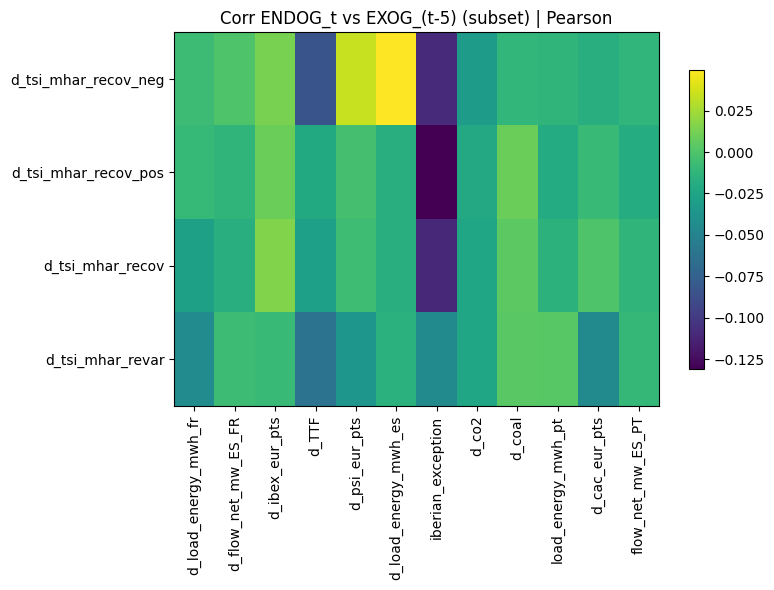

In [22]:
# Cross-correlation ENDOG_t vs EXOG_{t-L} for L = 1..5


lags = [1, 2, 3, 4, 5]
topK = 15  # exogs per endog to include in heatmap subset

all_top_tables = []

for L in lags:
    # Shift exog backward in time: exog_{t-L} aligns with endog_t
    exog_shift = exog[exog_names].shift(L)

    # Align and drop missing
    df = endog.join(exog_shift, how="inner")
    df = df[endog_names + exog_names].dropna()

    print("\n" + "#"*110)
    print(f"LAG = {L} | df shape after join+dropna: {df.shape} | {df.index.min()} -> {df.index.max()}")
    print("#"*110)

    # Build matrices
    Y = df[endog_names].to_numpy(dtype=float)   # T x m
    X = df[exog_names].to_numpy(dtype=float)    # T x k

    # Center
    Yc = Y - Y.mean(axis=0, keepdims=True)
    Xc = X - X.mean(axis=0, keepdims=True)

    # Std dev
    ys = Yc.std(axis=0, ddof=1)
    xs = Xc.std(axis=0, ddof=1)

    # Avoid division by zero (near-constant series)
    ys[ys == 0] = np.nan
    xs[xs == 0] = np.nan

    # Cov and corr
    cov = (Yc.T @ Xc) / (Yc.shape[0] - 1)       # m x k
    corr = cov / (ys[:, None] * xs[None, :])    # m x k

    corr_cross = pd.DataFrame(corr, index=endog_names, columns=exog_names)

    # Save full matrix
    csv_path = RESULTS_DIR / f"corr_endog_exog_lag{L}_pearson.csv"
    corr_cross.to_csv(csv_path)
    print("Saved full cross-corr CSV:", csv_path)

    # Build a top table: for each endog, top correlations by abs value
    rows = []
    for y in endog_names:
        s = corr_cross.loc[y].dropna()
        if s.empty:
            continue
        top = s.abs().sort_values(ascending=False).head(20).index
        for x in top:
            rows.append({"lag": L, "endog": y, "exog": x, "corr": corr_cross.loc[y, x], "abs_corr": abs(corr_cross.loc[y, x])})

    top_table = pd.DataFrame(rows).sort_values(["lag", "endog", "abs_corr"], ascending=[True, True, False])
    all_top_tables.append(top_table)

    display(top_table.head(30))

    top_csv = RESULTS_DIR / f"top_endog_exog_lag{L}_pearson.csv"
    top_table.drop(columns=["abs_corr"], errors="ignore").to_csv(top_csv, index=False)
    print("Saved top pairs CSV:", top_csv)

    # Heatmap subset for readability
    selected_exogs = set()
    for y in endog_names:
        s = corr_cross.loc[y].dropna()
        if s.empty:
            continue
        selected_exogs |= set(s.abs().sort_values(ascending=False).head(topK).index)

    selected_exogs = list(selected_exogs)
    corr_sub = corr_cross[selected_exogs]

    fig_path = RESULTS_DIR / f"heatmap_corr_endog_exog_lag{L}_pearson_subset.png"
    plot_heatmap(corr_sub, f"Corr ENDOG_t vs EXOG_(t-{L}) (subset) | Pearson", fig_path)
